In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('.'))

In [6]:
import numpy as np
import time
import datetime
import wandb
import gc
import pandas as pd
from train_helper import train_fn, valid_fn
from config import TrainConfig
from utils import get_logger, get_scheduler, load_pkl, weight_init
from dltime.data.ts_datasets import Soil_Dataset
from transformers import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
from data_process import handle_dataset_3dims, plot_time
from tqdm import tqdm

In [3]:
CFG = TrainConfig()

In [4]:
data_for_train = ['zwy', 'zwy2', 'zwy3', 'zwy4']
train_data = []
test_data = []
for data_name in data_for_train:
    train_data.extend(load_pkl(f'./pickle_data/{data_name}_train_{CFG.data_len}.pkl'))
    test_data.extend(load_pkl(f'./pickle_data/{data_name}_test_{CFG.data_len}.pkl'))

train_data = shuffle(train_data)
train_x, train_label = handle_dataset_3dims(train_data, mode='all')
test_x, test_label = handle_dataset_3dims(test_data, mode='all')
# train_x = np.swapaxes(train_x, 2, 1)
# test_x = np.swapaxes(test_x, 2, 1)
print('Train data size:', train_x.shape, train_label.shape)

Train data size: (4671, 5, 64) (4671,)


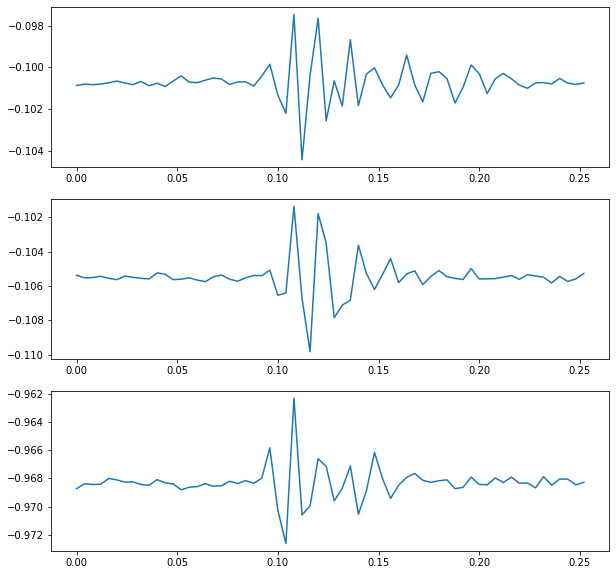

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
signal = train_data[0]['data_x']
sample_rate = 250
time = np.arange(0, len(signal)) * (1.0 / sample_rate)
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(time, train_data[0]['data_x'])
# plt.xlabel('Time(s)')
# plt.ylabel('Amplitude')
plt.subplot(3, 1, 2)
plt.plot(time, train_data[0]['data_y'])
plt.subplot(3, 1, 3)
plt.plot(time, train_data[0]['data_z'])
plt.show()

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier()
rocket.fit(train_x, train_label)
y_pred = rocket.predict(test_x)

In [7]:
accuracy_score(test_label, y_pred)

0.8150442477876106

In [8]:
data_for_test = ['sky', 'sky2', 'sky3']
data_len = 64
for data_name in tqdm(data_for_test):
    test_data = load_pkl(f'./pickle_data/{data_name}_train_{data_len}.pkl') + load_pkl(f'./pickle_data/{data_name}_test_{data_len}.pkl')
    test_x, test_label = handle_dataset_3dims(test_data, mode="all")
    y_pred = rocket.predict(test_x)
    score3class = accuracy_score(test_label, y_pred)
    score2class = accuracy_score(test_label==0, y_pred==0)
    print(data_name)
    print(score3class)
    print(score2class)
    print(confusion_matrix(test_label, y_pred))

 33%|███▎      | 1/3 [00:34<01:08, 34.50s/it]

sky
0.5846645367412141
0.6558649018712917
[[252  23 576]
 [113 298 149]
 [ 42   7 731]]


 67%|██████▋   | 2/3 [01:03<00:31, 31.16s/it]

sky2
0.7428256070640177
0.8107064017660044
[[488 180  87]
 [ 19 448  36]
 [ 57  87 410]]


100%|██████████| 3/3 [01:46<00:00, 35.64s/it]

sky3
0.7254255903349808
0.8176825919824272
[[520 136 146]
 [  8 382  45]
 [ 42 123 419]]


In [10]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=1)
hc2.fit(train_x, train_label)
y_pred = hc2.predict(test_x)
accuracy_score(test_label, y_pred)

KeyboardInterrupt: 

In [ ]:
data_for_test = ['sky', 'sky2', 'sky3']
data_len = 64
for data_name in tqdm(data_for_test):
    test_data = load_pkl(f'./pickle_data/{data_name}_train_{data_len}.pkl') + load_pkl(f'./pickle_data/{data_name}_test_{data_len}.pkl')
    test_x, test_label = handle_dataset_3dims(test_data, mode="all")
    y_pred = hc2.predict(test_x)
    score3class = accuracy_score(test_label, y_pred)
    score2class = accuracy_score(test_label==0, y_pred==0)
    print(data_name)
    print(score3class)
    print(score2class)
    print(confusion_matrix(test_label, y_pred))

In [12]:
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator

clf = DrCIF(n_estimators=10)
clf.fit(train_x, train_label)
clf.score(test_x, test_label)

0.7123893805309734

In [13]:
data_for_test = ['sky', 'sky2', 'sky3']
data_len = 64
for data_name in tqdm(data_for_test):
    test_data = load_pkl(f'./pickle_data/{data_name}_train_{data_len}.pkl') + load_pkl(f'./pickle_data/{data_name}_test_{data_len}.pkl')
    test_x, test_label = handle_dataset_3dims(test_data, mode="all")
    y_pred = clf.predict(test_x)
    score3class = accuracy_score(test_label, y_pred)
    score2class = accuracy_score(test_label==0, y_pred==0)
    print(data_name)
    print(score3class)
    print(score2class)
    print(confusion_matrix(test_label, y_pred))

 33%|███▎      | 1/3 [06:25<12:51, 385.95s/it]

sky
0.5381104518484711
0.6344135098128708
[[255  26 570]
 [153 212 195]
 [ 52  16 712]]


 67%|██████▋   | 2/3 [10:15<04:53, 293.96s/it]

sky2
0.6219646799116998
0.7224061810154525
[[345 221 189]
 [ 46 342 115]
 [ 47  67 440]]


100%|██████████| 3/3 [15:03<00:00, 301.27s/it]

sky3
0.615595826468973
0.7089511257550797
[[428 159 215]
 [ 65 261 109]
 [ 91  61 432]]


In [7]:
from sktime.classification.dictionary_based import MUSE
clf = MUSE()
clf.fit(train_x, train_label)
clf.score(test_x, test_label)

KeyboardInterrupt: 

In [ ]:
data_for_test = ['sky', 'sky2', 'sky3']
data_len = 64
for data_name in tqdm(data_for_test):
    test_data = load_pkl(f'./pickle_data/{data_name}_train_{data_len}.pkl') + load_pkl(f'./pickle_data/{data_name}_test_{data_len}.pkl')
    test_x, test_label = handle_dataset_3dims(test_data, mode="all")
    y_pred = clf.predict(test_x)
    score3class = accuracy_score(test_label, y_pred)
    score2class = accuracy_score(test_label==0, y_pred==0)
    print(data_name)
    print(score3class)
    print(score2class)
    print(confusion_matrix(test_label, y_pred))